# PREPROCESS

In [176]:
import pandas as pd
from pathlib import Path

In [177]:
DATA_DIR = Path('../data')
COLLECTED_DIR = DATA_DIR / 'collected' / 'csv_scraped'
PROCESSED_DIR = DATA_DIR / 'processed'
PHISH_DATA = COLLECTED_DIR / 'phished.csv'
LEGIT_DATA = COLLECTED_DIR / 'valid.csv'

In [178]:
df_phish = pd.read_csv(PHISH_DATA)
df_valid = pd.read_csv(LEGIT_DATA)

# Label

In [179]:
df_phish['result'] = -1
df_valid['result'] = 1

# Stats

In [180]:
from tabulate import tabulate

def create_table(data, headers):
    print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

In [181]:
def statistics(df):
    metrics = []
    data = []
    for col in df.columns:
        if col in {'id', 'timestamp', 'open_rank_domain', 'page_rank_integer', 'page_rank_decimal', 'website_url', 'sim_lev', 'sim_fuzz', 'num_of_subdomains', 'len_of_subdomains', 'result'}:
            continue
        
        value_counts = df[col].value_counts().reindex([-1, 0, 1], fill_value=0)
        phishing = value_counts.get(-1, 0)
        suspicious = value_counts.get(0, 0)
        legitimate = value_counts.get(1, 0)
        
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df['result'] = pd.to_numeric(df['result'], errors='coerce')
        
        TP = ((df[col] == -1) & (df['result'] == -1)).sum()
        FP = (((df[col] == -1) | (df[col] == 0)) & (df['result'] == 1)).sum()
        TN = ((df[col] == 1) & (df['result'] == 1)).sum()
        FN = (((df[col] == 1) | (df[col] == 0)) & (df['result'] == -1)).sum()
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0
        metrics.append({
            'Feature': col,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy
        })
        data.append([col, phishing, suspicious, legitimate, precision, recall, accuracy])


    headers = ["Feature","Phishing (-1)", "Suspicious (0)","Legitimate (1)", "Precision (%)", "Recall (%)", "Accuracy (%)"]
    create_table(data, headers)

## Phished Stats

In [182]:
statistics(df_phish)

╒════════════════════════════╤═════════════════╤══════════════════╤══════════════════╤═════════════════╤══════════════╤════════════════╕
│ Feature                    │   Phishing (-1) │   Suspicious (0) │   Legitimate (1) │   Precision (%) │   Recall (%) │   Accuracy (%) │
╞════════════════════════════╪═════════════════╪══════════════════╪══════════════════╪═════════════════╪══════════════╪════════════════╡
│ having_ip_address          │               0 │                0 │             2110 │               0 │   0          │     0          │
├────────────────────────────┼─────────────────┼──────────────────┼──────────────────┼─────────────────┼──────────────┼────────────────┤
│ url_length                 │             170 │              183 │             1757 │               1 │   0.0805687  │     0.0805687  │
├────────────────────────────┼─────────────────┼──────────────────┼──────────────────┼─────────────────┼──────────────┼────────────────┤
│ shortining_service         │           

# Valid Stats

In [183]:
statistics(df_valid)

╒════════════════════════════╤═════════════════╤══════════════════╤══════════════════╤═════════════════╤══════════════╤════════════════╕
│ Feature                    │   Phishing (-1) │   Suspicious (0) │   Legitimate (1) │   Precision (%) │   Recall (%) │   Accuracy (%) │
╞════════════════════════════╪═════════════════╪══════════════════╪══════════════════╪═════════════════╪══════════════╪════════════════╡
│ having_ip_address          │               0 │                0 │             2038 │               0 │            0 │     1          │
├────────────────────────────┼─────────────────┼──────────────────┼──────────────────┼─────────────────┼──────────────┼────────────────┤
│ url_length                 │             788 │              578 │              672 │               0 │            0 │     0.329735   │
├────────────────────────────┼─────────────────┼──────────────────┼──────────────────┼─────────────────┼──────────────┼────────────────┤
│ shortining_service         │           

# Combine and drop duplicates

In [184]:
df_combined = pd.concat([df_phish, df_valid], ignore_index=True)
df_combined.drop_duplicates(subset='website_url', inplace=True)

In [185]:
num_rows = df_combined.shape[0]
print(f"Number of rows in df_combined: {num_rows}")

Number of rows in df_combined: 4072


## Combined Stats

In [186]:
statistics(df_combined)

╒════════════════════════════╤═════════════════╤══════════════════╤══════════════════╤═════════════════╤══════════════╤════════════════╕
│ Feature                    │   Phishing (-1) │   Suspicious (0) │   Legitimate (1) │   Precision (%) │   Recall (%) │   Accuracy (%) │
╞════════════════════════════╪═════════════════╪══════════════════╪══════════════════╪═════════════════╪══════════════╪════════════════╡
│ having_ip_address          │               0 │                0 │             4072 │       0         │   0          │      0.481827  │
├────────────────────────────┼─────────────────┼──────────────────┼──────────────────┼─────────────────┼──────────────┼────────────────┤
│ url_length                 │             927 │              742 │             2403 │       0.114401  │   0.0805687  │      0.200393  │
├────────────────────────────┼─────────────────┼──────────────────┼──────────────────┼─────────────────┼──────────────┼────────────────┤
│ shortining_service         │           

# Feature Selection: Decision Tree and XGBoost

## Removing REDUNDANT and USELESS FEATURES

In [187]:
# id,timestamp,open_rank_domain,page_rank_integer,page_rank_decimal,website_url,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,port,https_token,request_url,url_of_anchor,links_in_tags,sfh,submitting_to_email,abnormal_url,redirect,on_mouseover,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,has_numbers,special_characters,lev,sim_lev,fuzzy,sim_fuzz,num_sub,num_of_subdomains,len_sub,len_of_subdomains,result
drop_useless_features = {
    'id',                   # NOT NEEDED
    'timestamp',            # NOT NEEDED
    'open_rank_domain',     # NOT NEEDED
    'page_rank_integer',    # NOT NEEDED
    'website_url',          # NOT NEEDED
    'sslfinal_state',       # BAD
    'having_ip_address',    # USELESS
    'port',                 # USELESS
    'https_token',          # Not useful
    'special_characters',   # Not useful
    'url_length',
    'links_pointing_to_page',
}

df_combined.drop(columns=drop_useless_features, inplace=True)

In [188]:
print(df_combined.dtypes)

page_rank_decimal             float64
shortining_service              int64
having_at_symbol                int64
double_slash_redirecting        int64
prefix_suffix                   int64
having_sub_domain               int64
domain_registration_length      int64
favicon                         int64
request_url                     int64
url_of_anchor                   int64
links_in_tags                   int64
sfh                             int64
submitting_to_email             int64
abnormal_url                    int64
redirect                        int64
on_mouseover                    int64
rightclick                      int64
popupwindow                     int64
iframe                          int64
age_of_domain                   int64
dnsrecord                       int64
web_traffic                     int64
page_rank                       int64
google_index                    int64
statistical_report              int64
has_numbers                     int64
lev         

In [189]:
X = df_combined.drop(columns=['result'])
y = df_combined['result']

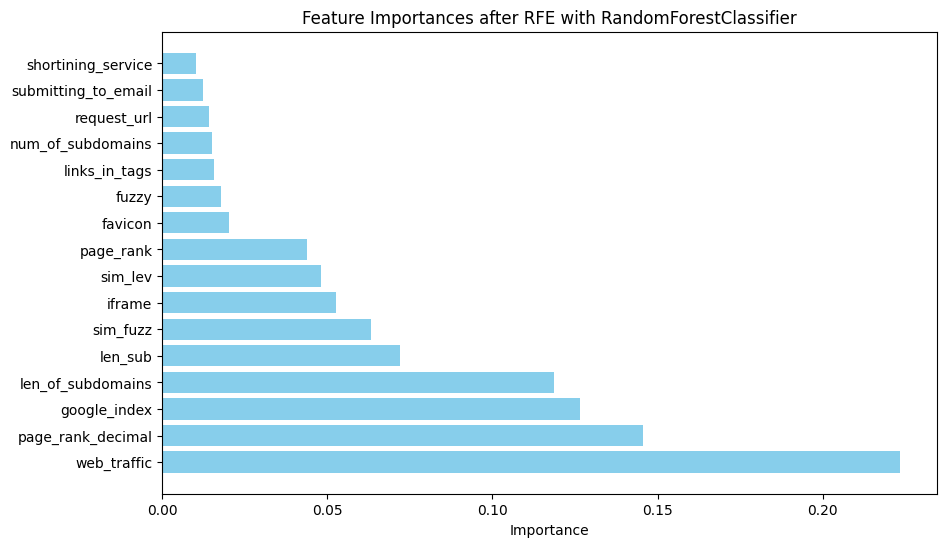

In [190]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import numpy as np

model = RandomForestClassifier(random_state=42, min_samples_leaf=1, max_features='sqrt')

selector = RFE(estimator=model, n_features_to_select=16)
X_selected = selector.fit_transform(X, y)
ranking = selector.ranking_

model.fit(X_selected, y)
importances = model.feature_importances_

feature_names = np.array(X.columns) if hasattr(X, 'columns') else np.arange(X.shape[1])

selected_features = feature_names[selector.support_]
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(selected_features[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances after RFE with RandomForestClassifier')
plt.show()


In [191]:
import pandas as pd

selected_features = feature_names[selector.support_]

if hasattr(X, 'columns'):
    X_selected_df = X[selected_features]
else:
    X_selected_df = X[:, selector.support_]

if hasattr(X, 'columns'):
    final_df = pd.concat([X_selected_df, pd.Series(y, name='result')], axis=1)
else:
    final_df = np.column_stack([X_selected_df, y])

final_df = final_df.sample(frac=1).reset_index(drop=True)
final_df.to_csv(PROCESSED_DIR / 'final_ref.csv', index=False)


In [192]:
print(final_df.columns)

Index(['page_rank_decimal', 'shortining_service', 'favicon', 'request_url',
       'links_in_tags', 'submitting_to_email', 'iframe', 'web_traffic',
       'page_rank', 'google_index', 'sim_lev', 'fuzzy', 'sim_fuzz',
       'num_of_subdomains', 'len_sub', 'len_of_subdomains', 'result'],
      dtype='object')


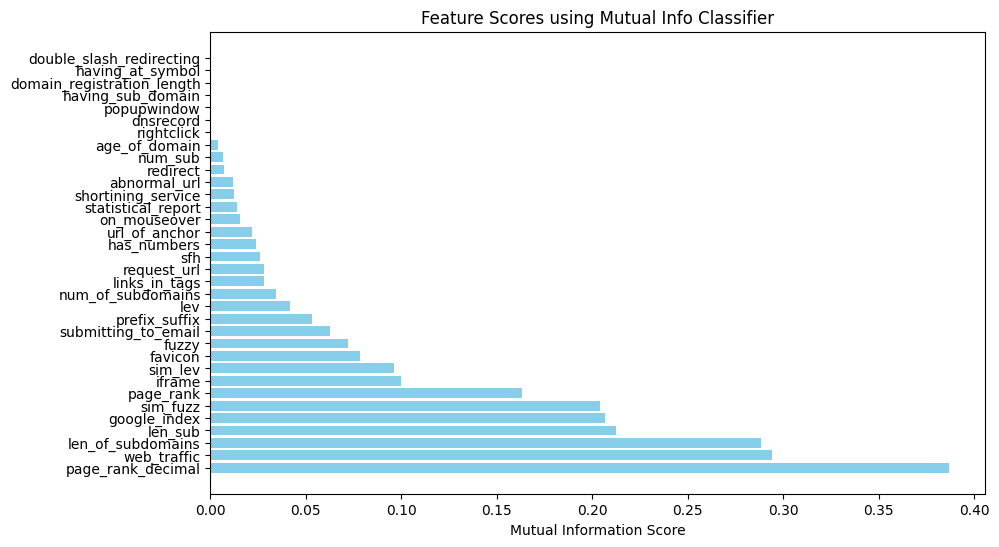

In [193]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_new = selector.fit_transform(X, y)

feature_scores = selector.scores_

feature_names = np.array(X.columns) if hasattr(X, 'columns') else np.arange(X.shape[1])

sorted_idx = np.argsort(feature_scores)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_scores[sorted_idx], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Feature Scores using Mutual Info Classifier')
plt.show()

In [ ]:
import json

threshold = 0.03

good_features = [feature for feature, score in zip(X.columns, feature_scores) if score > threshold]
bad_features = [feature for feature, score in zip(X.columns, feature_scores) if score <= threshold]

df_combined.drop(columns=bad_features, inplace=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)
df_combined.to_csv(PROCESSED_DIR / 'final.csv', index=False)

good_features_filename = '../configs/features/final_features.json'

with open(good_features_filename, 'w') as f:
    json.dump(good_features, f, indent=4)

print("List of Good Features:", good_features)

List of Good Features: ['page_rank_decimal', 'prefix_suffix', 'favicon', 'submitting_to_email', 'iframe', 'web_traffic', 'page_rank', 'google_index', 'lev', 'sim_lev', 'fuzzy', 'sim_fuzz', 'num_of_subdomains', 'len_sub', 'len_of_subdomains']


# Logistic Regression Feature Selection
## Fetch And preprocess Again

In [195]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [196]:
DATA_DIR = Path('../data')
COLLECTED_DIR = DATA_DIR / 'collected' / 'csv_scraped'
PROCESSED_DIR = DATA_DIR / 'processed'
PHISH_DATA = COLLECTED_DIR / 'phished.csv'
LEGIT_DATA = COLLECTED_DIR / 'valid.csv'

In [197]:
df_phish = pd.read_csv(PHISH_DATA)
df_valid = pd.read_csv(LEGIT_DATA)
df_phish['result'] = -1
df_valid['result'] = 1
df_combined = pd.concat([df_phish, df_valid], ignore_index=True)
df_combined.drop_duplicates(subset='website_url', inplace=True)
num_rows = df_combined.shape[0]
print(f"Number of rows in df_combined: {num_rows}")

Number of rows in df_combined: 4072


In [199]:
drop_useless_features = {
    'id',                   # NOT NEEDED
    'timestamp',            # NOT NEEDED
    'open_rank_domain',     # NOT NEEDED
    'page_rank_integer',    # NOT NEEDED
    'website_url',          # NOT NEEDED
    'sslfinal_state',       # BAD
    'having_ip_address',    # USELESS
    'port',                 # USELESS
    'https_token',          # Not useful
    'special_characters',   # Not useful
    'url_length',
    'links_pointing_to_page',
}

df_combined.drop(columns=drop_useless_features, inplace=True)

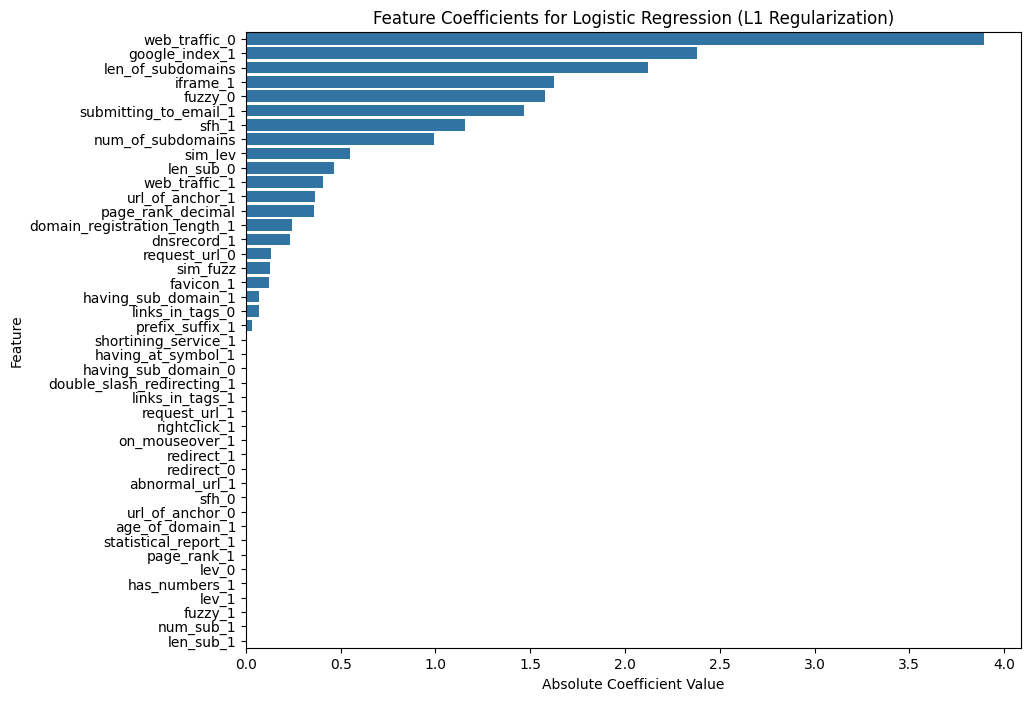

Selected features with non-zero coefficients: ['page_rank_decimal', 'sim_lev', 'sim_fuzz', 'num_of_subdomains', 'len_of_subdomains', 'prefix_suffix_1', 'having_sub_domain_1', 'domain_registration_length_1', 'favicon_1', 'request_url_0', 'url_of_anchor_1', 'links_in_tags_0', 'sfh_1', 'submitting_to_email_1', 'iframe_1', 'dnsrecord_1', 'web_traffic_0', 'web_traffic_1', 'google_index_1', 'fuzzy_0', 'len_sub_0']


In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X = df_combined.drop(columns=['result'])
y = df_combined['result']

continuous_cols = ['page_rank_decimal', 'sim_lev', 'sim_fuzz', 'num_of_subdomains', 'len_of_subdomains']
categorical_cols = [col for col in X.columns if col not in continuous_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),  # Scale continuous features
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # One-Hot encode categorical features
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=21))
])

pipeline.fit(X_train, y_train)

coefficients = pipeline.named_steps['model'].coef_[0]

transformed_columns = continuous_cols + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols))

feature_importance = pd.DataFrame({
    'Feature': transformed_columns,
    'Coefficient': coefficients
})

feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Coefficients for Logistic Regression (L1 Regularization)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

selected_features = [transformed_columns[i] for i, coef in enumerate(coefficients) if coef != 0]
print("Selected features with non-zero coefficients:", selected_features)

X_transformed = preprocessor.fit_transform(X)
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_columns)

final_data = pd.concat([X_transformed_df, y.reset_index(drop=True)], axis=1)

final_data = final_data[selected_features + ['result']]
final_data = final_data.sample(frac=1).reset_index(drop=True)
final_data.to_csv(PROCESSED_DIR/'final_lgr.csv', index=False)